# Importing Libraries

In [ ]:
import re
import os
import numpy as np 
import pandas as pd 
from sklearn.svm import SVC
import plotly.express as px
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import recall_score,precision_score,make_scorer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier,EasyEnsembleClassifier,RUSBoostClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



# Importing Data

In [ ]:
train = pd.read_json('/content/drive/MyDrive/datasets/Intent classification/is_train.json')
val = pd.read_json('/content/drive/MyDrive/datasets/Intent classification/is_val.json')
test = pd.read_json('/content/drive/MyDrive/datasets/Intent classification/is_test.json')
oos_train = pd.read_json('/content/drive/MyDrive/datasets/Intent classification/oos_train.json')
oos_val = pd.read_json('/content/drive/MyDrive/datasets/Intent classification/oos_val.json')
oos_test = pd.read_json('/content/drive/MyDrive/datasets/Intent classification/oos_test.json')

In [ ]:
train.columns=['text','intent']
val.columns=['text','intent']
test.columns=['text','intent']
oos_train.columns=['text','intent']
oos_val.columns=['text','intent']
oos_test.columns=['text','intent']

In [ ]:
train

text  \
0      what expression would i use to say i love you if i were an italian                                                                         
1      can you tell me how to say 'i do not speak much spanish', in spanish                                                                       
2      what is the equivalent of, 'life is good' in french                                                                                        
3      tell me how to say, 'it is a beautiful morning' in italian                                                                                 
4      if i were mongolian, how would i say that i am a tourist                                                                                   
5      how do i say 'hotel' in finnish                                                                                                            
6      i need you to translate the sentence, 'we will be there soon' into portuguese                                                              
7      please tell me how to ask for a taxi in french                                                                                             
8      can you tell me how i would say, 'more bread please' in french                                                                             
9      what is the correct way to say 'i am a visitor' in french                                                                                  
10     how would i say, 'i don't know the answer' in spanish                                                                                      
11     i would like to know the proper way to greet an adult in portuguese                                                                        
12     what words would i use to tell someone i am lost if i were japanese                                                                        
13     how would i say thank you if i were russian                                                                                                
14     can you tell me how i would normally say thank you as a french person                                                                      
15     i would like to know how to say hello in french                                                                                            
16     if i were english how would i say subway                                                                                                   
17     i would i say subway if i were english                                                                                                     
18     how do you say hi in french                                                                                                                
19     in england how do they say subway                                                                                                          
20     translate hello in french                                                                                                                  
21     how is hello said in french                                                                                                                
22     what do you call a subway if you were english                                                                                              
23     how would i say if i were english subway                                                                                                   
24     how should i say hello in french                                                                                                           
25     how could i say twin in chinese                                                                                                            
26     how can i say not now in spanish                                                                                                           
27     what do spanish 

# Data Preprocessing

In [ ]:
#checking for number of enteries
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15000 non-null  object
 1   intent  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4500 non-null   object
 1   intent  4500 non-null   object
dtypes: object(2)
memory usage: 70.4+ KB


So train dataset has 15000 enteries and test dataset has 4500 entries

## Checking for any null values

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())
print(val.isnull().sum())
print(oos_train.isnull().sum())
print(oos_val.isnull().sum())
print(oos_test.isnull().sum())

text      0
intent    0
dtype: int64
text      0
intent    0
dtype: int64
text      0
intent    0
dtype: int64
text      0
intent    0
dtype: int64
text      0
intent    0
dtype: int64
text      0
intent    0
dtype: int64


We can see that there are no null values present in our dataset 

# Checking for different types of intentions

In [ ]:
train.intent.value_counts()

translate                    100
order_status                 100
goodbye                      100
account_blocked              100
what_song                    100
international_fees           100
last_maintenance             100
meeting_schedule             100
ingredients_list             100
report_fraud                 100
measurement_conversion       100
smart_home                   100
book_hotel                   100
current_location             100
weather                      100
taxes                        100
min_payment                  100
pin_change                   100
accept_reservations          100
cancel                       100
how_busy                     100
bill_due                     100
calories                     100
damaged_card                 100
restaurant_reviews           100
routing                      100
do_you_have_pets             100
schedule_meeting             100
gas_type                     100
plug_type                    100
tire_chang

In [ ]:
len(train.intent.value_counts())

150

We can see that there are 150 different types of intents in our dataset

## Making N-Gram for better visualization

In [ ]:
def ngrams_top(corpus,ngram_range,n=10):
  #count vectorizer is being used for converting the text into matrix of vector counts 
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    #transforming into matrix
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #reverse sorting the frequencies
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    #choosing the number of columns we want to show
    total_list=words_freq[:n]
    #making the text and their counts dataframe for later visualization
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

Bigram is type of n-gram where we seeing the most number of occuring word pairs

In [ ]:
bigrams = ngrams_top(train.text,(2,2)).sort_values(by='count')
px.bar(data_frame=bigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#dc3912'],opacity=0.8,width=900,height=500)

We can change the text= to any higher value for any n-gram for better visualizing the group of words that are occuring frequently

# Functions for preprocessing part

In [ ]:
def binarize(data):
    data.intent = np.where(data.intent!='oos',0,1)# it means weher intent value is not oos then change it 0 otherwise make it 1
    return data

In [ ]:
#making a vectorizer for the text 
def vectorizer(X):
  #defining the count vectorizer
    cv = CountVectorizer(min_df=1,ngram_range=(1,2))
    #fitting and transforming the data
    X_en = cv.fit_transform(X)
    #returning the object as well as the vecotized text 
    return cv,X_en

In [ ]:
#making a labelencoder for the intent part
def labelencoder(y):
  #making object of labelenocder
    le = LabelEncoder()
    #fitting and transforming 
    le.fit(y)
    y_enc = le.transform(y)
    return le,y_enc

In [ ]:
#combining the both vectorizing and encoding function into a single text
def preprocess(train):
    X = train.text
    y = train.intent
    le,y = labelencoder(y)
    cv,X = vectorizer(X)
    return X,y,cv,le

In [ ]:
def process_non_train(df,cv,le):
    X = df.text
    y = df.intent
    X = cv.transform(X)
    y = le.transform(y)
    return X,y

In [ ]:
def get_score(clf,binary=0):
    clf.fit(X_train,y_train)
    if binary==1:
        y_pred = clf.predict(X_test)
        return clf,clf.score(X_val,y_val),clf.score(X_test,y_test),recall_score(y_test,y_pred),precision_score(y_test,y_pred)
    elif binary==0:
        return clf,clf.score(X_val,y_val),clf.score(X_test,y_test)

In [ ]:
X_train,y_train,cv,le = preprocess(train)
X_val,y_val = process_non_train(val,cv,le)
X_test,y_test = process_non_train(test,cv,le)

# Training over models

In [ ]:
val_scores = []
test_scores = []
names = []

models = [(KNeighborsClassifier(n_neighbors=15),'KNN'),(SGDClassifier(),'SGD clf'),(MultinomialNB(),'MultinomialNB'),
          (RandomForestClassifier(),'Random Forest'),(SVC(kernel='linear'),'Linear SVC')]

for model,name in models:
    clf,score,test_score = get_score(model,0)
    names.append(name)
    val_scores.append(score*100)
    test_scores.append(test_score*100)
pd.DataFrame(data=zip(val_scores,test_scores),index=names,columns=['val_score','test_score']).style.background_gradient()

# Searchinf for best parameters

In [ ]:
params = {
    'loss':['squared_hinge','modified_huber'],
    'alpha':[0.0001,0.001,0.01],
    'max_iter':[250,500,1000],
    'validation_fraction':[0.2]
}
cv = GridSearchCV(SGDClassifier(random_state=111),param_grid=params, cv=5,n_jobs=-1,verbose=2)

In [ ]:
cv.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=111), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'loss': ['squared_hinge', 'modified_huber'],
                         'max_iter': [250, 500, 1000],
                         'validation_fraction': [0.2]},
             verbose=2)

In [ ]:
cv.best_params_

{'alpha': 0.001,
 'loss': 'modified_huber',
 'max_iter': 250,
 'validation_fraction': 0.2}

In [ ]:
cv.best_score_

0.9207333333333333

## XGB 

In [ ]:
#using XGB classifier
import xgboost as xgb

In [ ]:
xgb_cl_default = xgb.XGBClassifier()

In [ ]:
xgb_cl_default.fit(X_train,y_train)
y_pred_xgb_df=xgb_cl_default.predict(X_test)
score_xgb_df=accuracy_score(y_test, y_pred_xgb_df)

In [ ]:
score_xgb_df

0.8713333333333333

The default XGB classifier gave us an accuracy of 0.82

In [ ]:
#lets play with some parameters 
xgb_cl= xgb.XGBClassifier(learning_rate=0.05,gamma=0.3,max_depth=30)

In [ ]:
xgb_cl.fit(X_train,y_train)
y_pred_xgb=xgb_cl.predict(X_test)
score_xgb=accuracy_score(y_test, y_pred_xgb)

In [ ]:
score_xgb

XGb didn't perform that much good so the results are in front of us so the model SGD clf performs the best

# For out of scope predictions

In [ ]:
oos_plus_train = binarize(pd.concat([train,oos_train],axis=0).reset_index(drop=True))
oos_plus_val = binarize(pd.concat([val,oos_val],axis=0).reset_index(drop=True))
oos_plus_test = binarize(pd.concat([test,oos_test],axis=0).reset_index(drop=True))

In [ ]:
oos_count = oos_plus_train.intent.value_counts()
oos_count

0    15000
1    100  
Name: intent, dtype: int64

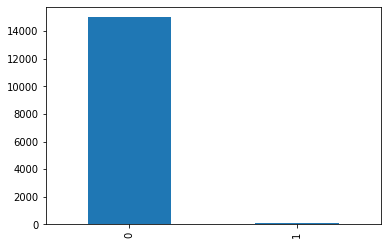

In [ ]:
oos_count.plot(kind='bar')

In case of out of scope predictions we have highly imbalanced data with an imbalanced ratio of150 to 1 so we have to use some imbalanced classifiers

In [ ]:
X_train,y_train,cv,le = preprocess(oos_plus_train)
X_val,y_val = process_non_train(oos_plus_val,cv,le)
X_test,y_test = process_non_train(oos_plus_test,cv,le)

In [ ]:
val_scores = []
test_scores = []
recall = []
names = []
precision = []

models = [(BalancedRandomForestClassifier(sampling_strategy='not minority',random_state=111),'Balanced Random Forest'),
          (RUSBoostClassifier(base_estimator=LogisticRegression(),sampling_strategy='not minority',random_state=111),'Random Undersampling + Adaboost'),
          ]

for model,name in models:
    _,score,test_score,recall_sc,precision_sc = get_score(model,1)
    names.append(name)
    val_scores.append(score*100)
    test_scores.append(test_score*100)
    recall.append(recall_sc*100)
    precision.append(precision_sc*100)
pd.DataFrame(data=zip(val_scores,test_scores,recall,precision),index=names,
             columns=['val_score','test_score','recall_score','precision_score']).style.background_gradient()